In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift, fft2, ifft2
from scipy.integrate import simps
from scipy.interpolate import interp2d
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from propagation import laser
from ionization import ionization
from ionization import adk
from lens import profile
from lens import bessel
from lens import ray
import numpy.ma as ma
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy.random as rm
import warnings
plt.style.use('notes')

path = '/media/robert/Data_Storage/Data/Experimental/Test_Optic_1/'
lam = 0.796
tau = 30 # RMS pulse length in fs, needs to be updated if optical design changes
L = 30e4 # Distance between optics, needs to be updated if optical design changes
w0 = 15e3 # Radius of the super Gaussian, needs to be updated if optical design changes
plasma_start, plasma_end = np.load(path+'plasma_size.npy')
# All length units are in um

In [2]:
# Load the lens phase patterns from a file
# Create the first lens
Nx = 2**12 # These will be overwritten by the saved versions
X = 40e3
lensParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'path' : path,
              'name' : 'LensAD',
              'lam' : lam,
              'load' : True}

lensA = optic.Phase(lensParams)

# Create the second lens
lensParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'path' : path,
              'name' : 'LensBD',
              'lam' : lam,
              'load' : True}

lensB = optic.Phase(lensParams)

# Create a generic initial beam so we can use the member methods
Nx0 = lensA.Nx
X0 = lensA.X
beamParams = {'Nx' : Nx0,
              'Ny' : Nx0,
              'X' : X0,
              'Y' : X0,
              'lam' : lam,
              'path' : path,
              'name' : 'Beam0_Generic',
              'threads' : 4,
              'cyl' : True,
              'load' : False}

beam0 = laserbeam.Laser(beamParams)
E = np.load(path+'initial_E.npy')
r = np.load(path+'initial_r.npy')
path2 = path + 'BaseLens/'
e = beam0.reconstruct_from_cyl(r, E, beam0.x, beam0.y)

# Number of cells for each propagation step
Nz0 = 100
Nz1 = 200
Nz2 = 200

In [3]:
# For plotting we need a single grid to overlay images on
def plot_beam_path(beam0, beam1, beam2, I0, I1, I2, Z0, Z1, Z2, X0, X1, X2, Nz0, Nz1, Nz2, Nx0, Nx1, Nx2):
    I0p = beam0.prep_data(I0)
    I1p = beam1.prep_data(I1)
    I2p = beam2.prep_data(I2)
    Z = Z0+Z1+Z2
    ext0 = [0, Z/1e3, -X0/2e3, X0/2e3]

    I0m = np.zeros((int(Nx0*X0/X0), int(Nz0*Z/Z0)))
    I0m = ma.asarray(I0m)
    I0m[:, :] = ma.masked
    I0m[:, :Nz0] = I0p

    Nx = int(Nx1*X0/X1)
    Nz = int(Nz1*Z/Z1)
    I1m = np.zeros((int(Nx1*X0/X1), int(Nz1*Z/Z1)))
    I1m = ma.asarray(I1m)
    I1m[:, :] = ma.masked
    I1m[int((Nx-Nx1)/2):int((Nx-Nx1)/2)+Nx1, int(Nz1*Z0/Z1):int(Nz1*Z0/Z1)+Nz1] = I1p

    Nx = int(Nx2*X0/X2)
    Nz = int(Nz2*Z/Z2)
    I2m = np.zeros((int(Nx2*X0/X2), int(Nz2*Z/Z2)))
    I2m = ma.asarray(I2m)
    I2m[:, :] = ma.masked
    I2m[int((Nx-Nx2)/2):int((Nx-Nx2)/2)+Nx2, int(Nz2*(Z0+Z1)/Z2):] = I2p

    norm = colors.LogNorm(vmin=1e-3, vmax=30)
    plt.figure(figsize=(8, 2), dpi=150)
    plt.imshow(I0m, aspect='auto', extent=ext0, norm=norm)
    plt.imshow(I1m, aspect='auto', extent=ext0, norm=norm)
    plt.imshow(I2m, aspect='auto', extent=ext0, norm=norm)
    cb = plt.colorbar()
    cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
    plt.xlabel('z (m)')
    plt.ylabel('x (mm)')
    plt.show()

In [4]:
# Lets check the plasma density without refraction in He
def plot_plasma_den(ne, Z2, X2):
    plt.figure(figsize=(8, 2), dpi=150)
    plt.imshow(np.transpose(np.flipud(ne)), aspect='auto', extent=[0, Z2/1e6, -X2/2, X2/2], cmap='plasma')
    cb = plt.colorbar()
    cb.set_label(r'Ionization fraction')
    plt.ylim(-500, 500)
    plt.xlabel(r'z (m)')
    plt.ylabel(r'x (um)')
    plt.show()

In [5]:
# Plot the beam's transverse intensity at three different places
def plot_transverse_intensity(beam0, beam1, beam2, Et0, Et1, Et2, X0):
    It0 = beam0.intensity_from_field(Et0)
    It0 = beam0.prep_data(It0)
    It1 = beam1.intensity_from_field(Et1)
    It1 = beam1.prep_data(It1)
    It2 = beam2.intensity_from_field(Et2)
    It2 = beam2.prep_data(It2)

    plt.figure(figsize=(8, 2), dpi=150)
    plt.subplot(131)
    im = plt.imshow(It0, aspect='equal', extent=[-X0/2e3, X0/2e3, -X0/2e3, X0/2e3], cmap='viridis')
    cb = plt.colorbar()
    plt.xlabel(r'x (mm)')
    plt.ylabel(r'y (mm)')

    plt.subplot(132)
    im = plt.imshow(It1, aspect='equal', extent=[-X0/2e3, X0/2e3, -X0/2e3, X0/2e3], cmap='viridis')
    cb = plt.colorbar()
    plt.xlabel(r'x (mm)')

    plt.subplot(133)
    im = plt.imshow(It2, aspect='equal', extent=[-X0/2e3, X0/2e3, -X0/2e3, X0/2e3], cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
    plt.xlabel(r'x (mm)')
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

    plt.tight_layout()
    plt.show()

In [6]:
# Propagate a series of laser beams through the lenses and into the plasma
def propagate_laser(path2, e, plot_path=False, plot_plasma=False, plot_et=False):
    # First step, propagate the incoming beam through lens A and up to lens B
    Z0 = L
    z0 = np.linspace(0, Z0, Nz0)
    Nx0 = lensA.Nx
    X0 = lensA.X
    beamParams = {'Nx' : Nx0,
                  'Ny' : Nx0,
                  'X' : X0,
                  'Y' : X0,
                  'lam' : lam,
                  'path' : path2,
                  'name' : 'Beam0_A_to_B',
                  'threads' : 4,
                  'cyl' : True,
                  'load' : False}

    beam0 = laserbeam.Laser(beamParams)
    beam0.initialize_field(e)
    Et0 = beam0.e
    interactions.beam_phase(beam0, lensA)
    beam0.propagate(z0, 1.0)

    # Second step, propagate through lens B and up to the start of the plasma
    Z1 = plasma_start
    z1 = np.linspace(0, Z1, Nz1)
    Nx1 = lensB.Nx
    X1 = lensB.X
    beamParams = {'Nx' : Nx1,
                  'Ny' : Nx1,
                  'X' : X1,
                  'Y' : X1,
                  'lam' : lam,
                  'path' : path2,
                  'name' : 'Beam1_B_to_plasma',
                  'threads' : 4,
                  'cyl' : True,
                  'load' : False}

    beam1 = laserbeam.Laser(beamParams)
    e = beam1.rescale_field(beam0, beam1)
    beam1.initialize_field(e)
    interactions.beam_phase(beam1, lensB)
    Et1 = beam1.e
    beam1.propagate(z1, 1.0)

    # Third step, propagate through the region with plasma
    Z2 = plasma_end - plasma_start
    z2 = np.linspace(0, Z2, Nz2)
    Nx2 = 2**12
    X2 = 10e3
    beamParams = {'Nx' : Nx2,
                  'Ny' : Nx2,
                  'X' : X2,
                  'Y' : X2,
                  'lam' : lam,
                  'path' : path2,
                  'name' : 'Beam2_plasma',
                  'threads' : 4,
                  'cyl' : True,
                  'load' : False}

    beam2 = laserbeam.Laser(beamParams)
    e = beam2.rescale_field(beam1, beam2)
    beam2.initialize_field(e)
    beam2.propagate(z2[:int(Nz2/2)], 1.0)
    Et2 = beam2.e
    beam2.propagate(z2[1:int(Nz2/2)+1], 1.0)
    
    # Load the fields from each beam
    e0 = np.zeros((Nz0, Nx0), dtype='complex128')
    for i in range(Nz0):
        e0[i, :] = beam0.load_field(i+1)[0]
    e1 = np.zeros((Nz1, Nx1), dtype='complex128')
    for i in range(Nz1):
        e1[i, :] = beam1.load_field(i+1)[0]
    e2 = np.zeros((Nz2, Nx2), dtype='complex128')
    for i in range(Nz2):
        e2[i, :] = beam2.load_field(i+1)[0]
    I0 = beam0.intensity_from_field(e0)
    I1 = beam1.intensity_from_field(e1)
    I2 = beam2.intensity_from_field(e2)
    
    atom = ionization.He
    ne = adk.gaussian_frac(atom['EI'], abs(e2), tau, atom['Z'], atom['l'], atom['m'])
    
    # Plotting routines
    if plot_path:
        plot_beam_path(beam0, beam1, beam2, I0, I1, I2, Z0, Z1, Z2, X0, X1, X2, Nz0, Nz1, Nz2, Nx0, Nx1, Nx2)
    if plot_plasma:
        plot_plasma_den(ne, Z2, X2)
    if plot_et:
        plot_transverse_intensity(beam0, beam1, beam2, Et0, Et1, Et2, X0)
        
    return ne, e2

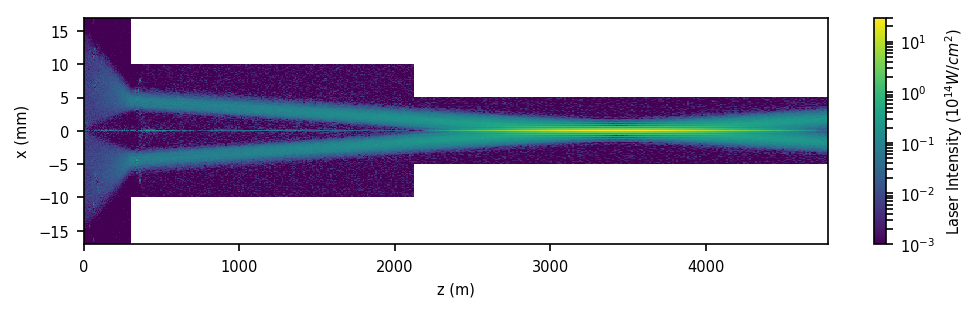

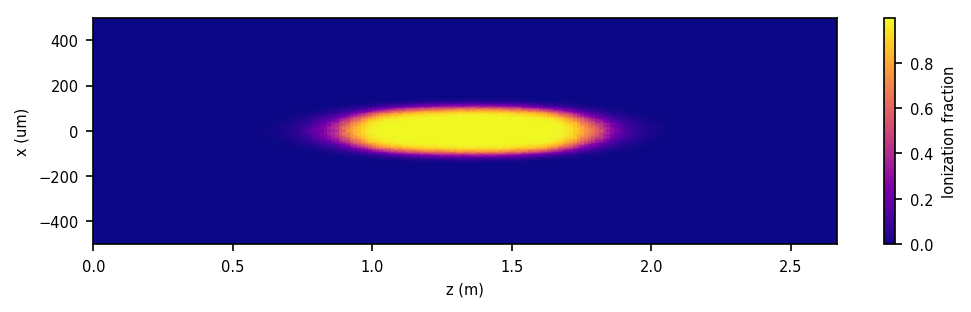

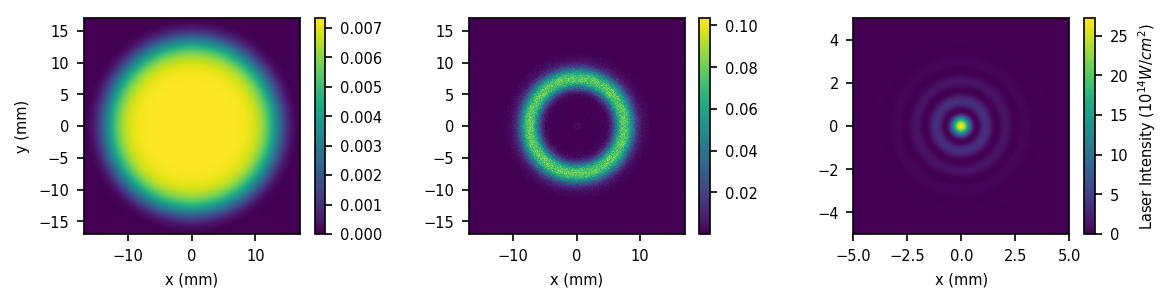

In [7]:
# Initial laser optic design
ne, e2 = propagate_laser(path2, e, True, True, True)

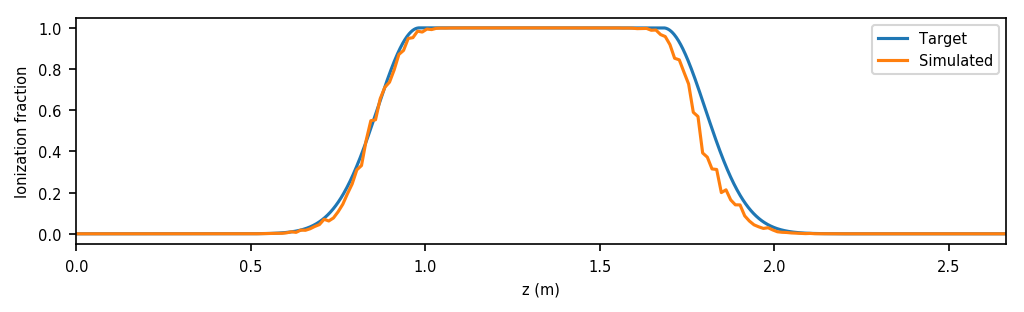

In [23]:
# Plot the plasma profile produced by the beam
plasma0 = np.load(path+'plasma.npy')
plasma_z = plasma0[0] - plasma_start
plasma_n = plasma0[1]
Z2 = plasma_end - plasma_start
z2 = np.linspace(0, Z2, Nz2)/1e6

plt.figure(figsize=(8, 2), dpi=150)
ax = plt.subplot()
plt.plot(plasma_z/1e6, plasma_n)
plt.plot(z2, ne[:, int(Nx/2)])
plt.xlabel('z (m)')
plt.ylabel('Ionization fraction')
plt.xlim(0, (plasma_end - plasma_start)/1e6)
plt.legend(['Target', 'Simulated'])
plt.show()

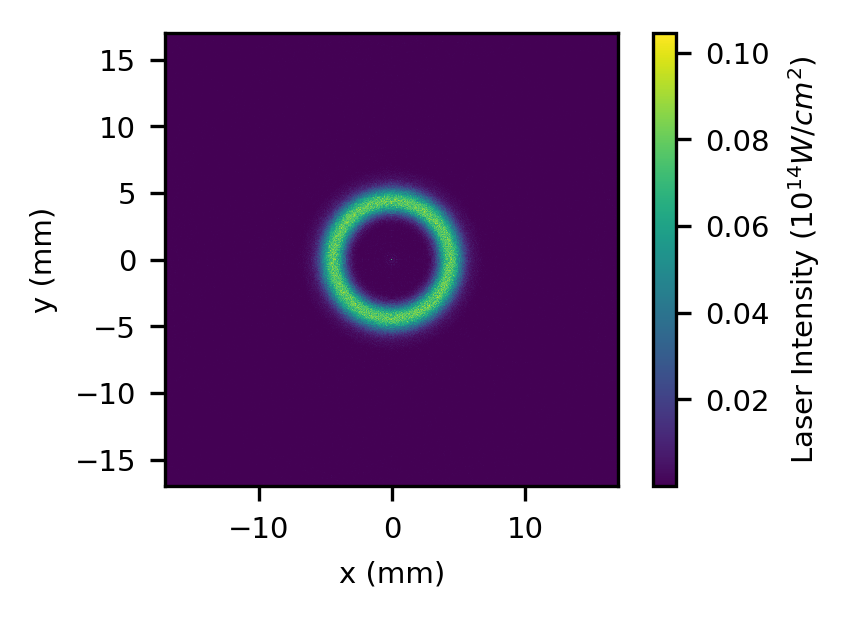

In [27]:
# Lets see if the image resampling step is the problem
Z0 = L
Nx0 = lensA.Nx
X0 = lensA.X
beamParams = {'Nx' : Nx0,
              'Ny' : Nx0,
              'X' : X0,
              'Y' : X0,
              'lam' : lam,
              'path' : path2,
              'name' : 'Beam0_A_to_B',
              'threads' : 4,
              'cyl' : True,
              'load' : False}

beam0 = laserbeam.Laser(beamParams)
beam0.initialize_field(e)
interactions.beam_phase(beam0, lensA)
beam0.propagate(Z0, 1.0)

I = beam0.intensity_from_field(beam0.e)
plt.figure(figsize=(3, 2), dpi=300)
im = plt.imshow(I, aspect='equal', extent=[-X0/2e3, X0/2e3, -X0/2e3, X0/2e3], cmap='viridis')
cb = plt.colorbar()
cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
plt.xlabel(r'x (mm)')
plt.ylabel(r'y (mm)')
plt.show()

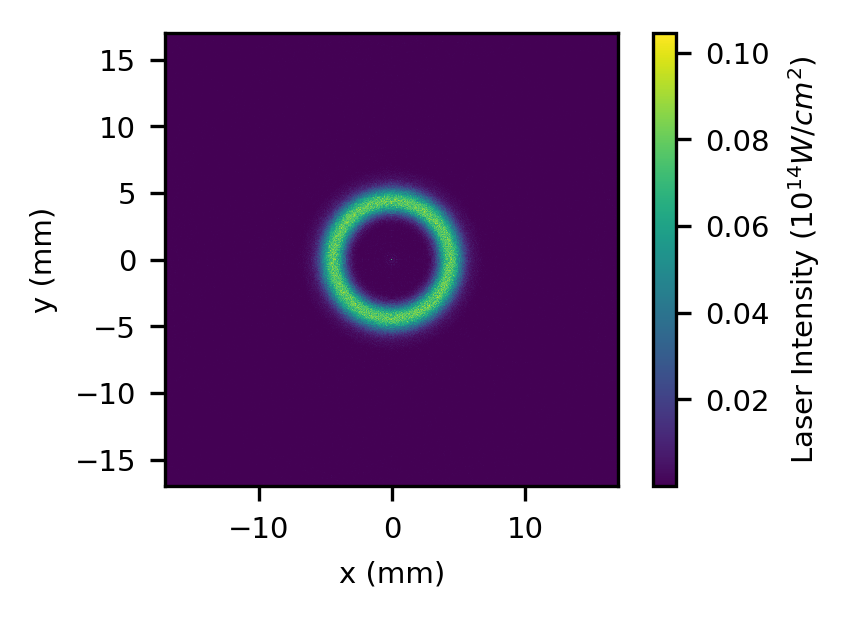

In [28]:
# Second step, propagate through lens B and up to the start of the plasma
Z1 = plasma_start
Nx1 = lensB.Nx
X1 = lensB.X
beamParams = {'Nx' : Nx1,
              'Ny' : Nx1,
              'X' : X1,
              'Y' : X1,
              'lam' : lam,
              'path' : path2,
              'name' : 'Beam1_B_to_plasma',
              'threads' : 4,
              'cyl' : True,
              'load' : False}

beam1 = laserbeam.Laser(beamParams)
e = beam1.rescale_field(beam0, beam1)
beam1.initialize_field(e)

I = beam0.intensity_from_field(beam0.e)
plt.figure(figsize=(3, 2), dpi=300)
im = plt.imshow(I, aspect='equal', extent=[-X0/2e3, X0/2e3, -X0/2e3, X0/2e3], cmap='viridis')
cb = plt.colorbar()
cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
plt.xlabel(r'x (mm)')
plt.ylabel(r'y (mm)')
plt.show()